`Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv Download Google_Stock_Price_Train.csv).`

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
stock = pd.read_csv('Google_Stock_Price_Train.csv')

`Step 2. Preprocess the data as you see fit`

In [3]:
stock.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

In [4]:
stock.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [6]:
print(stock['Date'].max())
print(stock['Date'].min())

9/9/2016
1/10/2012


In [7]:
stock = stock.drop(columns=['Volume'])

In [8]:
for c in ['Close']:
    stock[c] = stock[c].replace(regex=',', value='')
    stock[c] = stock[c].astype(float)

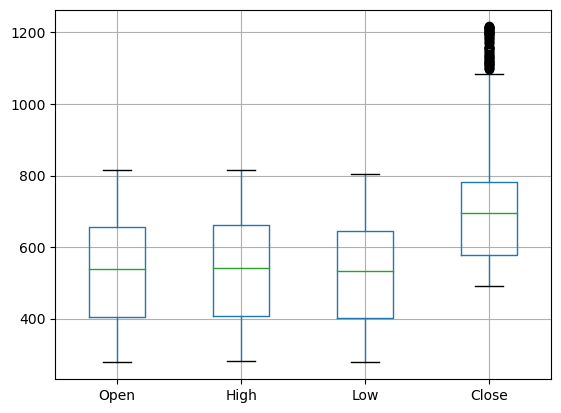

In [9]:
stock.boxplot()
plt.show()

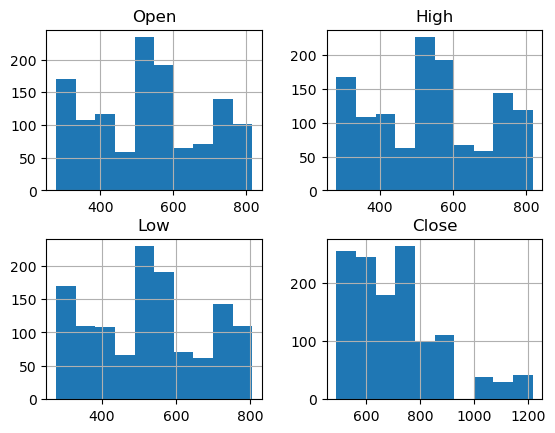

In [10]:
_ = stock.hist(bins=10)
plt.show()

`Step 3. Split into 80% train 20% prediction`

In [15]:
# dataset = stock.drop(columns=['Date']).values
dataset = stock[['Open']].values

In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [17]:
# Range Normalization
sc = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = sc.fit_transform(dataset)

In [18]:
# Create a data structure with 60 time-steps and 1 output
x_train, x_test, y_train, y_test = [], [], [], []
train_size = int(np.ceil(stock.shape[0] * 0.8))
for i in range(60, train_size):
    x_train.append(scaled_dataset[i - 60 : i, [0]])
    y_train.append(scaled_dataset[i, [0]])
x_train, y_train = np.array(x_train), np.array(y_train)

for i in range(train_size, stock.shape[0]):
    x_test.append(scaled_dataset[i - 60 : i, [0]])
    y_test.append(scaled_dataset[i, [0]])
x_test, y_test = np.array(x_test), np.array(y_test)

`Step 4. Train the model on the data`

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
early_stopping = EarlyStopping(monitor="loss", mode="min", verbose=2, patience=10)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=x_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
30/30 [==============================] - 5s 17ms/step - loss: 0.0400
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0054
Epoch 3/100
30/30 [==============================] - 0s 17ms/step - loss: 0.0048
Epoch 4/100
30/30 [==============================] - 0s 17ms/step - loss: 0.0041
Epoch 5/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0039
Epoch 6/100
30/30 [==============================] - 0s 17ms/step - loss: 0.0040
Epoch 7/100
30/30 [==============================] - 0s 17ms/step - loss: 0.0038
Epoch 8/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0036
Epoch 9/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0039
Epoch 10/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0035
Epoch 11/100
30/30 [==============================] - 0s 17ms/step - loss: 0.0036
Epoch 12/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 13/100
30/30 [=====

`Step 5. Report on the results of your model`

In [26]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
actual_stock_price = sc.inverse_transform(y_test)

8/8 [==============================] - 0s 23ms/step


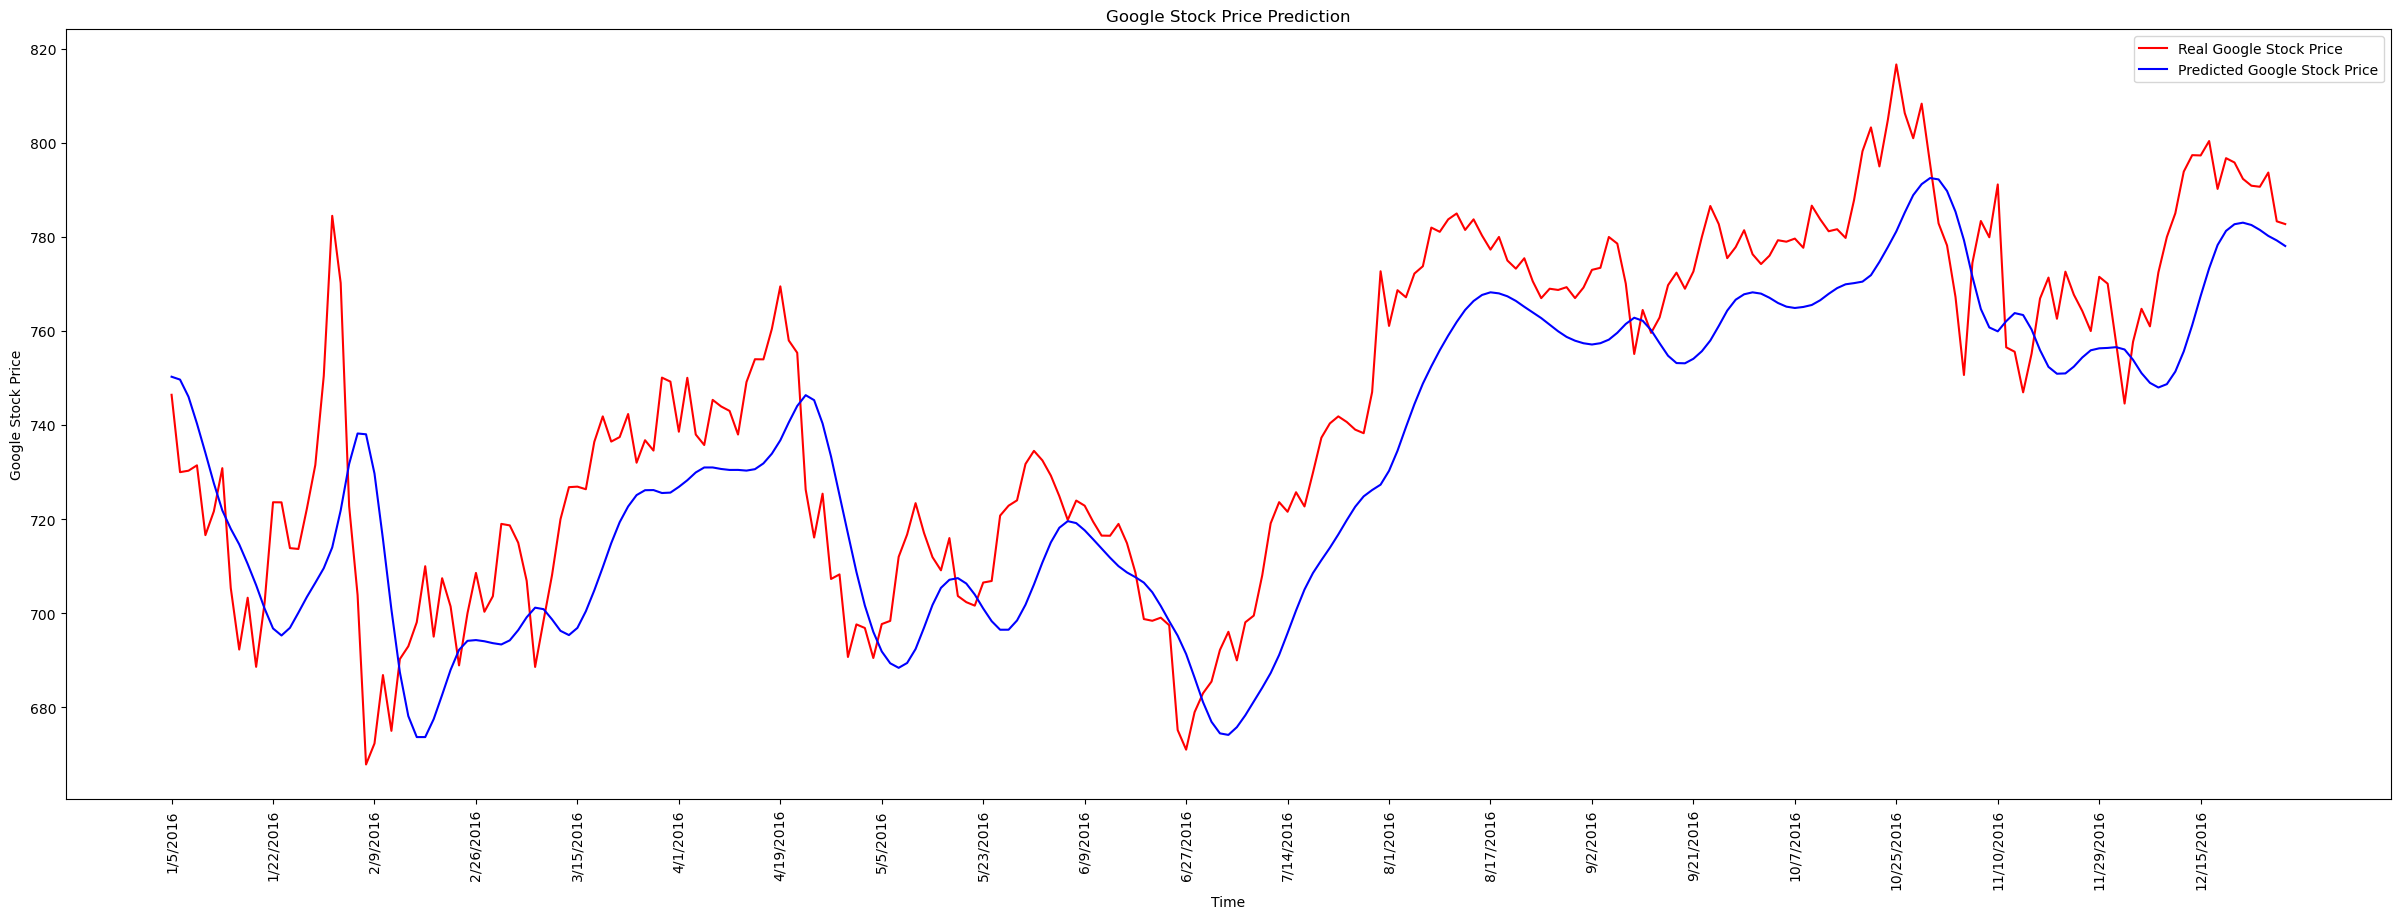

In [54]:
from datetime import datetime

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(stock.loc[train_size:, 'Date'], actual_stock_price, color = 'red', label = 'Real Google Stock Price')
ax.plot(stock.loc[train_size:, 'Date'], predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
ax.set_title('Google Stock Price Prediction')
plt.xticks(np.arange(0, len(stock) - train_size, 12), rotation=90)
ax.set_xlabel('Time')
ax.set_ylabel('Google Stock Price')
ax.legend()
plt.show()

The model is able to make predictions to a lower opening price, but couldn't predict too well on price that is high.